In [2]:
%load_ext autoreload
%autoreload 2


# Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score
from tqdm import tqdm
import scipy.cluster.hierarchy as sch

from utils import *



In [3]:
# Dataset
data = pd.read_csv("msdata.csv")
data.head()

,id,class,f1,f2,f3,f4,f5,f6,f7,f8,...,f4991,f4992,f4993,f4994,f4995,f4996,f4997,f4998,f4999,f5000
0,1,1,13.5668,10.9921,12.8019,18.8665,18.3896,13.8447,14.6832,13.6332,...,14.8549,14.6290,13.6823,16.4846,14.0313,14.5499,15.3994,15.8356,15.4092,10.9560
1,2,1,14.4608,10.0654,13.1336,20.1350,20.3564,14.9173,14.4468,14.0363,...,17.0840,14.5755,13.9338,18.4931,13.7288,14.4361,15.7231,15.6006,15.3425,13.7905
2,3,1,13.6018,11.3929,12.9640,20.3422,18.7408,14.3422,15.1872,13.3086,...,14.6561,14.7897,14.6149,16.3884,12.7930,14.0828,16.7488,16.3542,14.2886,13.2870
3,4,1,13.5682,9.8825,13.2593,19.4111,20.5106,13.7343,12.7313,13.7213,...,17.3763,14.5456,14.1032,17.5769,12.5236,15.0141,16.4015,14.5762,15.9415,8.4923
4,5,1,13.1236,11.6153,12.9775,20.2562,19.5410,14.7275,15.5866,13.0861,...,16.5775,14.5145,14.8090,18.0071,15.1559,14.2589,16.4705,15.9093,14.2622,11.4655


## Feature analysis

In [26]:
# check for missing values
data.isnull().sum().sum()

0

In [27]:
# check datatype of features
dtypes = [data[col].dtypes for col in data.columns[2:]]
set(dtypes)   

{dtype('float64')}

## Preprocessing

### Data dimension reduction

We can use Principal Component Analysis to reduce the dimensionality of the data while still keeping most of the variance of the original data.

PCA works by creating an eigendecomposition of the data matrix and transforming the data using the first k eigenvectors corresponding to the largest eigenvalues. 

In [4]:
datasets = ['zscore', 'minmax', 'mean']
datas_reduced_pca = [preprocess(data, method, reduce_method='pca', idx_cols=2, std_pca=True, pca_pct=2) for method in tqdm(datasets)]
datas_reduced_umap = [preprocess(data, method, reduce_method='umap', idx_cols=2, std_pca=True) for method in tqdm(datasets)]

100%|██████████| 3/3 [00:27<00:00,  9.02s/it]


In [5]:
datas_reduced_umap[0].head()

,0,1
0,5.132875,4.885714
1,5.120437,4.901415
2,5.127740,4.892401
3,5.140326,4.875905
4,5.135141,4.882713


In [20]:
datas_reduced_pca[0].head()

,0
0,4.060151
1,6.047730
2,5.084757
3,4.293928
4,5.378516


In [31]:
# plot_hist(datas_reduced_umap[0])

## K-means clustering

100%|██████████| 12/12 [00:16<00:00,  1.35s/it]


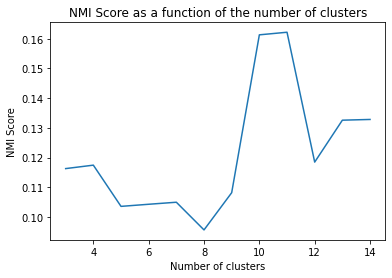

0.16215940045582147


In [19]:
scores = []
n_clusters = range(3, 15)
truth = data['class'].values - 1
for k in tqdm(n_clusters):
    preds, km = kmeans(data[data.columns.values[2:]], k)
    score = nmi(truth, preds, k)
    scores.append(score)
plt.plot(n_clusters, scores)
plt.xlabel("Number of clusters")
plt.ylabel("NMI Score")
plt.title("NMI Score as a function of the number of clusters")
plt.savefig('plots/ms/kmeans_no_prep.png')
plt.show()

print(max(scores))

100%|██████████| 13/13 [00:01<00:00, 12.01it/s]


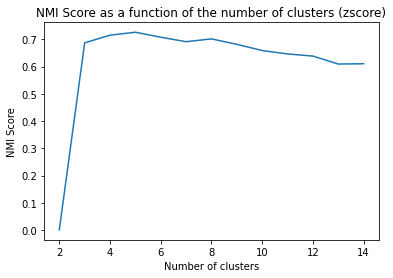

100%|██████████| 13/13 [00:01<00:00, 12.02it/s]


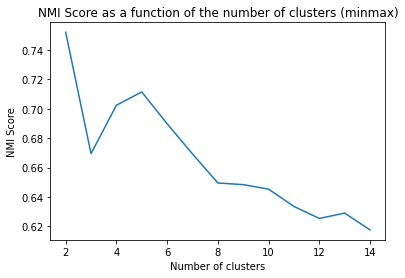

100%|██████████| 13/13 [00:01<00:00, 12.33it/s]


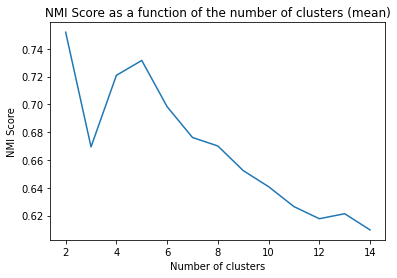

0.7519526000396546


In [20]:
for data_reduced, method in zip(datas_reduced_pca, datasets):
    scores = []
    n_clusters = range(2, 15)
    truth = data['class'].values - 1
    for k in tqdm(n_clusters):
        preds, km = kmeans(data_reduced, k)
        score = nmi(truth, preds, k)
        scores.append(score)
    plt.plot(n_clusters, scores)
    plt.xlabel("Number of clusters")
    plt.ylabel("NMI Score")
    plt.title("NMI Score as a function of the number of clusters (" + method + ")")
    plt.savefig(f'plots/ms/kmeans_pca_{method}.png')
    plt.show()

    print(max(scores))

100%|██████████| 13/13 [00:01<00:00,  8.65it/s]


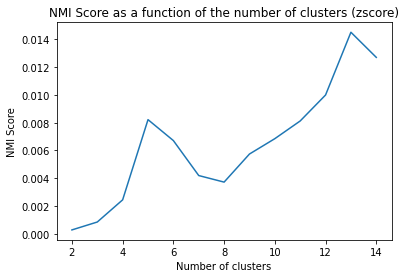

100%|██████████| 13/13 [00:01<00:00,  8.46it/s]


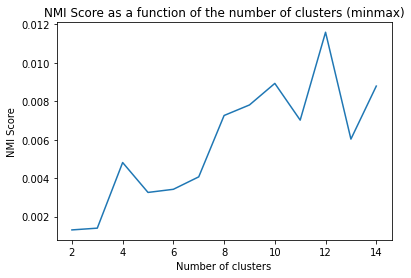

100%|██████████| 13/13 [00:01<00:00,  8.80it/s]


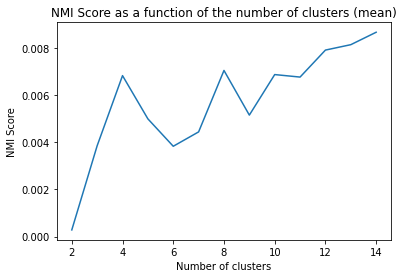

0.008667087604677163


In [21]:
best_preds = []
best_score = 1

for data_reduced, method in zip(datas_reduced_umap, datasets):
    scores = []
    n_clusters = range(2, 15)
    truth = data['class'].values - 1
    for k in tqdm(n_clusters):
        preds, km = kmeans(data_reduced, k)
        score = nmi(truth, preds, k)
        scores.append(score)
        if score < best_score:
            best_score = score
            best_preds = preds
    plt.plot(n_clusters, scores)
    plt.xlabel("Number of clusters")
    plt.ylabel("NMI Score")
    plt.title("NMI Score as a function of the number of clusters (" + method + ")")
    plt.savefig(f'plots/ms/kmeans_umap_{method}.png')
    plt.show()

    print(max(scores))

## Hierarchical clustering

In [27]:
linkages = ['single', 'complete', 'average']
linkages_func = [sch.single, sch.complete, sch.average]


In [32]:
best_score = 0
best_preds = []

scores_pca = {}
for d in datasets:
    scores_pca[d] = dict(zip(linkages, [[] for x in range(len(linkages))]))

for data_reduced, dataset in zip(datas_reduced_pca, datasets):
    n_clusters = range(2, 35)
    truth = data['class'].values - 1
    for k in tqdm(n_clusters):
        scores = agglo_func(data_reduced, linkages, linkages_func, k, dataset, scores_pca, truth)
        for score, preds in scores:
            if (score > best_score):
                best_score = score
                best_preds = preds
        # score = nmi(truth, preds, k)
        # scores.append(score)


100%|██████████| 33/33 [00:00<00:00, 39.05it/s]


In [17]:
with open('ms_result.txt', 'w') as f:
    for p in best_preds:
        f.write(f'{p} \n')

In [29]:
scores_umap = {}
for d in datasets:
    scores_umap[d] = dict(zip(linkages, [[] for x in range(len(linkages))]))

for data_reduced, dataset in zip(datas_reduced_umap, datasets):
    n_clusters = range(3, 35)
    truth = data['class'].values - 1
    for k in tqdm(n_clusters):
        agglo_func(data_reduced, linkages, linkages_func, k, dataset, scores_umap, truth)
        # score = nmi(truth, preds, k)
        # scores.append(score)


100%|██████████| 32/32 [00:00<00:00, 37.02it/s]


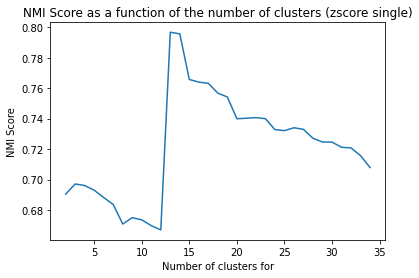

0.7966964960915287


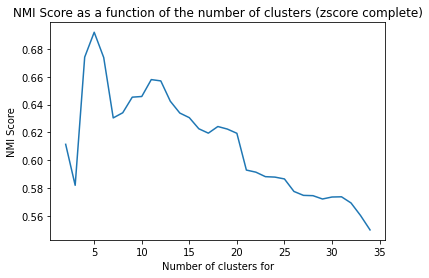

0.6920547993211765


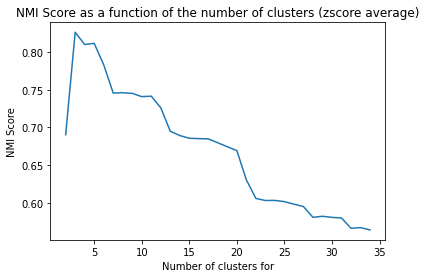

0.8265559167102271


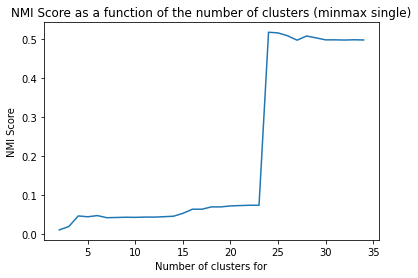

0.5182435660815476


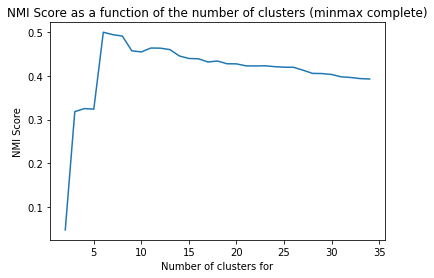

0.5001979433484077


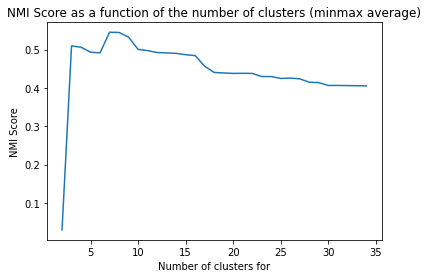

0.5454159362767226


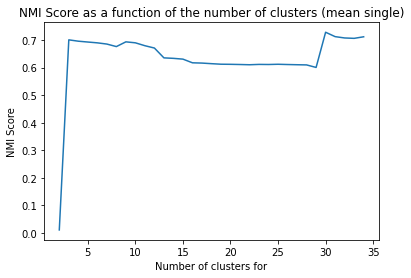

0.7283735899089425


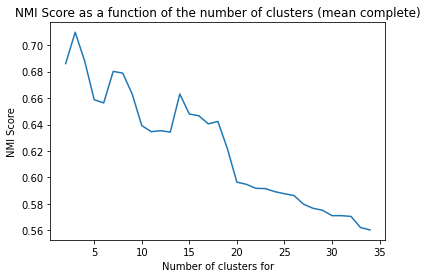

0.7097425957635453


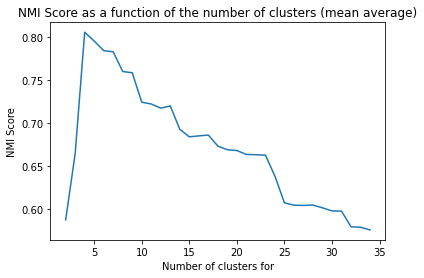

0.8059411432384531


In [33]:

for datas in scores_pca.keys():
    for link in scores_pca[datas].keys():
        score_arr = scores_pca[datas][link]
        plt.plot(n_clusters, score_arr)
        plt.xlabel("Number of clusters for")
        plt.ylabel("NMI Score")
        plt.title(f"NMI Score as a function of the number of clusters ({datas} {link})")
        plt.savefig(f'plots/ms/hier_pca_{datas}_{link}.png')
        plt.show()
        print(max(score_arr))

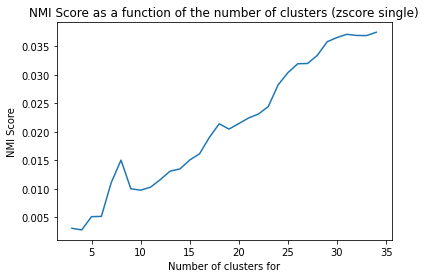

0.03747468768786561


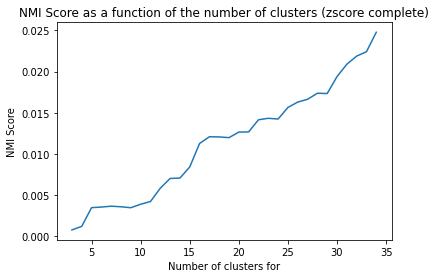

0.024783169228438512


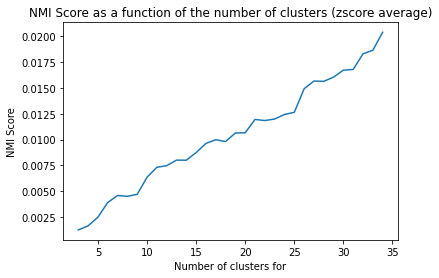

0.020374293879755635


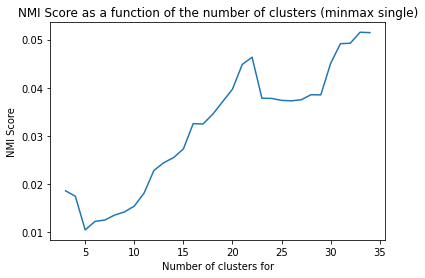

0.051525035837603275


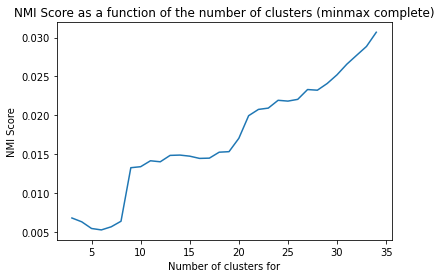

0.03069504458810876


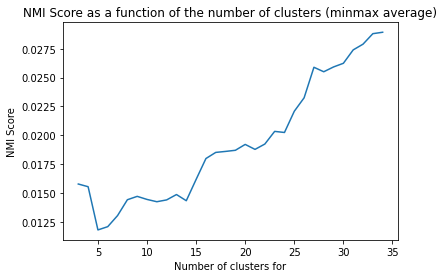

0.02892974713782626


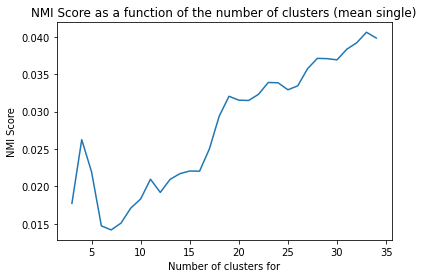

0.04059758939967688


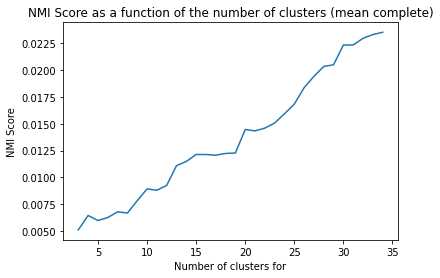

0.023549050127778682


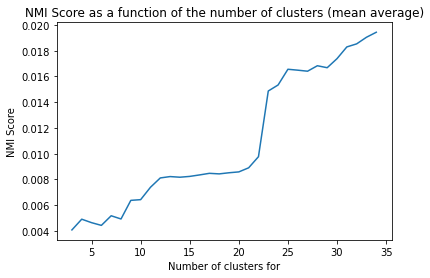

0.019432435737228127


In [31]:

for datas in scores_umap.keys():
    for link in scores_umap[datas].keys():
        score_arr = scores_umap[datas][link]
        plt.plot(n_clusters, score_arr)
        plt.xlabel("Number of clusters for")
        plt.ylabel("NMI Score")
        plt.title(f"NMI Score as a function of the number of clusters ({datas} {link})")
        plt.savefig(f'plots/ms/hier_umap_{datas}_{link}.png')
        plt.show()
        print(max(score_arr))

### Without preprocessing

In [41]:
score_np = {'data': {}}
score_np['data'] = dict(zip(linkages, [[] for x in range(len(linkages))]))

In [42]:
for k in tqdm(n_clusters):
    agglo_func(data, linkages, linkages_func, k, 'data', score_np, truth)

100%|██████████| 32/32 [01:35<00:00,  2.99s/it]


In [ ]:
for link in score_np['data'].keys():
    score_arr = score_np['data'][link]
    plt.plot(n_clusters, score_arr)
    plt.xlabel("Number of clusters for")
    plt.ylabel("NMI Score")
    plt.title(f"NMI Score as a function of the number of clusters ({link})")
    plt.savefig(f'plots/ms/hier_no_prep_{link}.png')
    plt.show()
    print(max(score_arr))

## DBSCAN

100%|██████████| 12/12 [00:00<00:00, 54.67it/s]


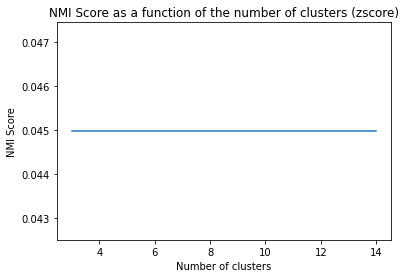

100%|██████████| 12/12 [00:00<00:00, 83.62it/s]
0.04498413614037765


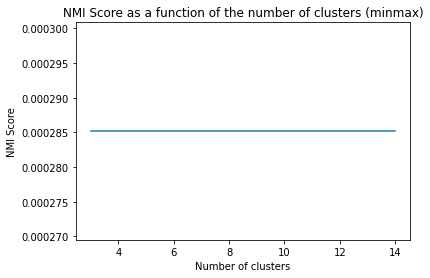

100%|██████████| 12/12 [00:00<00:00, 79.47it/s]
0.0002851828772007909


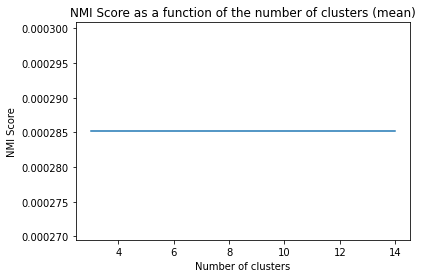

0.0002851828772007909


In [13]:
for data_reduced, method in zip(datas_reduced_pca, datasets):
    scores = []
    n_clusters = range(3, 15)
    truth = data['class'].values - 1
    for k in tqdm(n_clusters):
        preds, db = dbscan(data_reduced)
        score = nmi(truth, preds, k)
        scores.append(score)
    plt.plot(n_clusters, scores)
    plt.xlabel("Number of clusters")
    plt.ylabel("NMI Score")
    plt.title("NMI Score as a function of the number of clusters (" + method + ")")
    plt.show()

    print(max(scores))

100%|██████████| 12/12 [00:00<00:00, 88.78it/s]


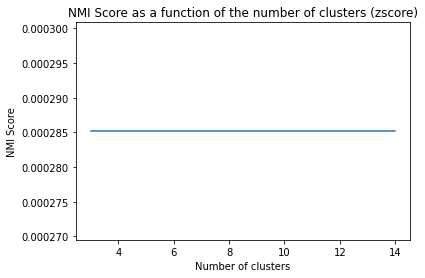

100%|██████████| 12/12 [00:00<00:00, 94.49it/s]0.0002851828772007909



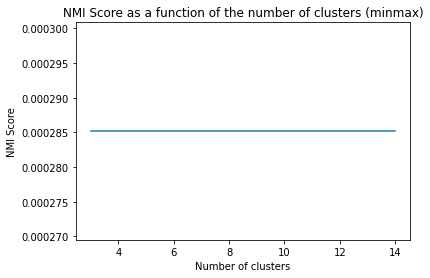

100%|██████████| 12/12 [00:00<00:00, 85.11it/s]0.0002851828772007909



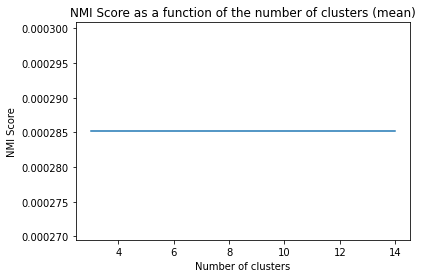

0.0002851828772007909


In [14]:
for data_reduced, method in zip(datas_reduced_umap, datasets):
    scores = []
    n_clusters = range(3, 15)
    truth = data['class'].values - 1
    for k in tqdm(n_clusters):
        preds, db = dbscan(data_reduced)
        score = nmi(truth, preds, k)
        scores.append(score)
    plt.plot(n_clusters, scores)
    plt.xlabel("Number of clusters")
    plt.ylabel("NMI Score")
    plt.title("NMI Score as a function of the number of clusters (" + method + ")")
    plt.show()

    print(max(scores))

### Without preprocessing

In [29]:
for data_reduced, method in zip(data, datasets):
    # scores = []
    truth = data['class'].values - 1
    preds, db = dbscan(data[data.columns.values[2:]])
    score = nmi(truth, preds, 0)
    scores.append(score)
    # plt.plot(n_clusters, scores)
    # plt.xlabel("Number of clusters")
    # plt.ylabel("NMI Score")
    # plt.title("NMI Score as a function of the number of clusters (" + method + ")")
    # plt.show()

    print(max(scores))

0.25
0.25
0.25


## Spectral clustering

### PCA

100%|██████████| 13/13 [00:01<00:00,  8.51it/s]


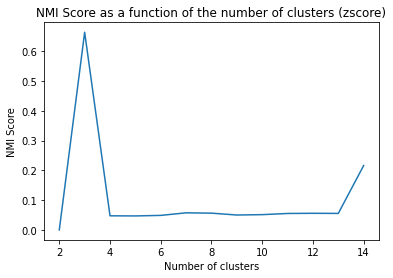

100%|██████████| 13/13 [00:33<00:00,  2.61s/it]


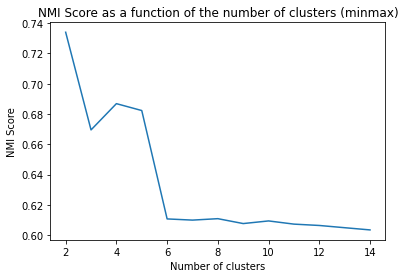

100%|██████████| 13/13 [00:27<00:00,  2.10s/it]


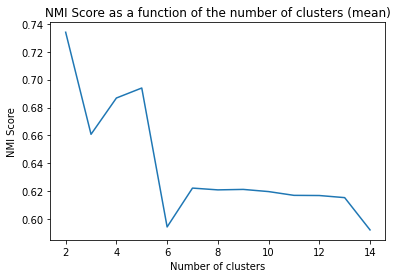

0.7339609131400201


In [36]:
for data_reduced, method in zip(datas_reduced_pca, datasets):
    scores = []
    n_clusters = range(2, 15)
    truth = data['class'].values - 1
    for k in tqdm(n_clusters):
        preds, km = spectral(data_reduced, k)
        score = nmi(truth, preds, k)
        scores.append(score)
    plt.plot(n_clusters, scores)
    plt.xlabel("Number of clusters")
    plt.ylabel("NMI Score")
    plt.title("NMI Score as a function of the number of clusters (" + method + ")")
    plt.savefig(f'plots/ms/spectral_pca_{method}.png')
    plt.show()

    print(max(scores))

100%|██████████| 13/13 [00:01<00:00,  6.94it/s]


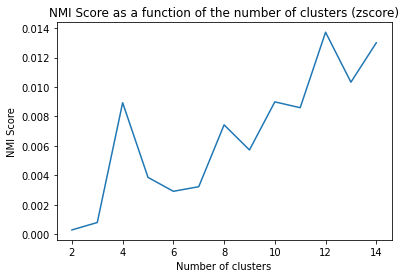

100%|██████████| 13/13 [00:14<00:00,  1.10s/it]


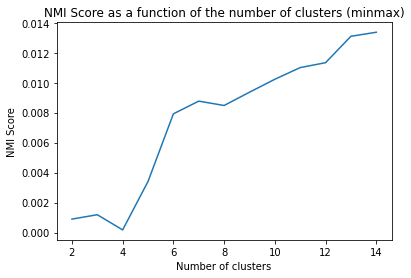

100%|██████████| 13/13 [00:16<00:00,  1.31s/it]


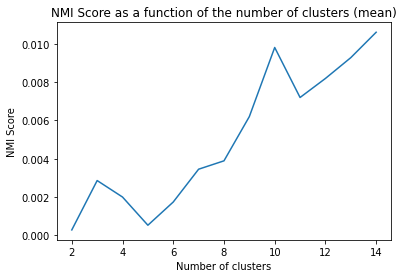

0.010602077559853294


In [35]:
for data_reduced, method in zip(datas_reduced_umap, datasets):
    scores = []
    n_clusters = range(2, 15)
    truth = data['class'].values - 1
    for k in tqdm(n_clusters):
        preds, km = spectral(data_reduced, k)
        score = nmi(truth, preds, k)
        scores.append(score)
    plt.plot(n_clusters, scores)
    plt.xlabel("Number of clusters")
    plt.ylabel("NMI Score")
    plt.title("NMI Score as a function of the number of clusters (" + method + ")")
    plt.savefig(f'plots/ms/spectral_umap_{method}.png')
    plt.show()

    print(max(scores))